# Classify
텔레마케팅 캠페인 데이터로부터 정기예금 가입 여부를 예측하기 위한 분류기입니다.

# Import modules

In [1]:
# enable in-line MatPlotLib
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

In [2]:
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, classification_report
from util import *

# Preprocess

In [3]:
RANDOM_SEED = 99

# Read data
df = pd.read_csv("dataset.tsv", delimiter='\t')

In [4]:
# Replace Korean with English & Encode yes/no category
replace_dict = {
    "x4":{"저학력":"low", "중학력":"middle", "고학력":"high"},
    "x9":{"유선":"wired", '무선':"wireless"},
    "x5":{"yes":1, "no":0},
    "x7":{"yes":1, "no":0},
    "x8":{"yes":1, "no":0},
    "y":{"yes":1, "no":0},
    "x11":{"jan":1, "feb":2, "mar":3, "apr":4, "may":5, "jun":6, \
           "jul":7, "aug":8, "sep":9, "oct":10, "nov":11, "dec":12}
    }

df.replace(replace_dict, inplace=True)

date(x10)와 month(x11)는 시간 형태의 데이터로 순환(cyclic)이 될 수 있도록 transform 합니다. 단순히 One-hot-encoding 할 경우 cyclic 특성이 반영되지 않을 수 있기 때문입니다.

In [5]:
# Transform days and months into circular numeric data
days_in_month = 31
df['x10_sin_date'] = np.sin(2*np.pi*df['x10']/days_in_month)
df['x10_cos_date'] = np.cos(2*np.pi*df['x10']/days_in_month)
df.drop('x10', axis=1, inplace=True)

months_in_year = 12
df['x11_sin_month'] = np.sin(2*np.pi*df['x11']/months_in_year)
df['x11_cos_month'] = np.cos(2*np.pi*df['x11']/months_in_year)
df.drop('x11', axis=1, inplace=True)

In [6]:
# Make dummy variables for (multiple)categorical data
obj_df = df.select_dtypes(include=['object']).copy()
df = pd.get_dummies(data=df,
                    columns=list(obj_df),
                    drop_first = False)

df = df.astype(float)
df['y'] = df['y'].astype(int)

In [7]:
df.head()

,x1,x5,x6,x7,x8,x12,x13,x14,y,x10_sin_date,...,x4_low,x4_middle,x4_unknown,x9_unknown,x9_wired,x9_wireless,x15_failure,x15_other,x15_success,x15_unknown
0,58.0,0.0,2143.0,1.0,0.0,1.0,-1.0,0.0,0,0.848644,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,44.0,0.0,29.0,1.0,0.0,1.0,-1.0,0.0,0,0.848644,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,33.0,0.0,2.0,1.0,1.0,1.0,-1.0,0.0,0,0.848644,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,47.0,0.0,1506.0,1.0,0.0,1.0,-1.0,0.0,0,0.848644,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,33.0,0.0,1.0,0.0,0.0,1.0,-1.0,0.0,0,0.848644,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


다양한 기준의 Outlier detection을 활용하여 데이터 탐색 단계에서 검출된 x6, x6, x12, x13의 out-lier를 처리합니다. (x6, x12, x13)의 Plot은 생략합니다.

(Warning 메세지는 Seaborn 패키지 내부에서 발생: https://github.com/mwaskom/seaborn/issues/953)

/Users/Kyunghee/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


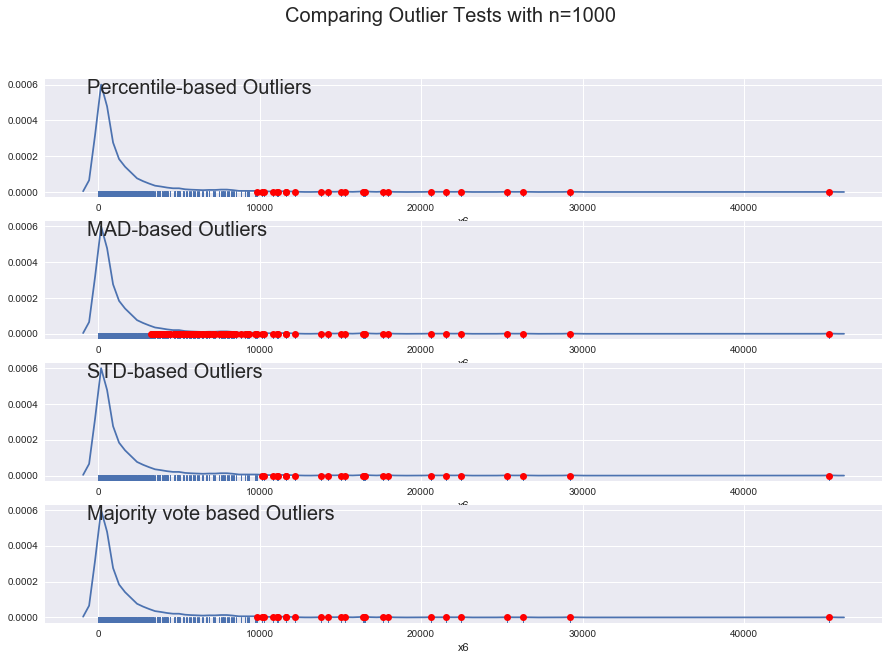

In [9]:
# Modify Out-lier
# for x6
plotOutlier(df['x6'].sample(1000))
df.x6 = modify_max_outlier(df, col='x6', max=6000)

In [11]:
# for x12
#plotOutlier(df['x12'].sample(1000))
df.x12 = modify_max_outlier(df, col='x12', max=20)

# for x13
#plotOutlier(df['x13'].sample(1000))
df.x13 = modify_max_outlier(df, col='x13', max=370)

# for x14
#plotOutlier(df['x14'].sample(1000))
df.x14 = modify_max_outlier(df, col='x14', max=30)

# Split Dataset

In [12]:
y = df.y
X = df.drop('y', axis=1)

# Train:60%, Valid:20%, Test:20%
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                     test_size=0.2,
                                     train_size=0.8,
                                     random_state=RANDOM_SEED)

X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train,
                                      test_size=0.25,
                                      train_size=0.75,
                                      random_state=RANDOM_SEED)

# Sanity-check that the data sets have been split representatively
for dataset in (y_train, y_valid, y_test):
    print('%i rows: %f yes rates' %(len(dataset), dataset.sum() / len(dataset)))

24000 rows: 0.121958 yes rates
8000 rows: 0.123875 yes rates
8000 rows: 0.122875 yes rates


# Classification Model

Numeric/Categorical data가 혼합된 경우 많이 사용되는 Random Forest Classifier와 Gradient Boosting Model 두가지를 사용합니다.
Numeric data의 normalization 또는 scaling이 필요없고, unknown categorical data를 처리하지 않아도 되는 점이 장점입니다.
일반적인 경우 두 모델은 뛰어난 성능을 보입니다. (참고: https://www.cs.cornell.edu/~caruana/ctp/ct.papers/caruana.icml06.pdf)

# Random Forest
Estimator의 수를 변화시키며 최적의 hyper parameter를 결정합니다. (실행 시간의 제약상 과정은 생략, 600으로 사용)
AUC와 accuracy 결과를 출력합니다.

In [2]:
#Find the optimal number of random forest estimators
rf_auc = []
nTreeList = range(400, 1000, 50)
for iTrees in nTreeList:
    rf_model = RandomForestClassifier(n_estimators=iTrees,
                                    max_depth=None,
                                    max_features='auto',
                                    bootstrap=True,
                                    oob_score=False,
                                    random_state=RANDOM_SEED)
    
    rf_model.fit(X=X_train, y=y_train)
    rf_pred = rf_model.predict_proba(X=X_valid)
    aucCal = roc_auc_score(y_valid, rf_pred[:,1])
    rf_auc.append(aucCal)

print(max(rf_auc))
print(rf_auc.index(max(rf_auc)))

plt.figure(1)
plt.plot(nTreeList, rf_auc, linewidth=2)
plt.xlabel('Number of Trees in Ensemble')
plt.ylabel('AUC')
plt.show()

NameError: name 'RandomForestClassifier' is not defined

In [14]:
# Random forest model
rf_model = RandomForestClassifier(n_estimators=600,
                                max_depth=None,
                                max_features='auto',
                                min_samples_split=2,
                                min_samples_leaf=1,
                                bootstrap=True,
                                oob_score=False,
                                random_state=RANDOM_SEED)

rf_model.fit(X=X_train, y=y_train)

rf_pred = rf_model.predict_proba(X=X_valid)
aucCal = roc_auc_score(y_valid, rf_pred[:,1])

print("AUC - Random Forest: %f" %(aucCal))
print(accuracy_score(y_valid, rf_model.predict(X_valid)))

AUC - Random Forest: 0.789095
0.885


# Gradient Boosting Model
순차적으로 작동하는 모델의 특성상 실행 완료 후 AUC를 최대화하는 Tree stage를 기준으로 결과를 출력합니다.

In [15]:
# Gradient boosting model
gb_model = GradientBoostingClassifier(n_estimators=600,
                                      max_depth=10,
                                      learning_rate=0.01,
                                      max_features=None)

gb_model.fit(X=X_train, y=y_train)

gb_auc = []
gb_aucBest = 0.0
gb_pred = gb_model.staged_decision_function(X_valid)
for p in gb_pred:
    aucCalc = roc_auc_score(y_valid, p)
    gb_auc.append(aucCalc)
    
    if aucCalc > gb_aucBest:
        gb_aucBest = aucCalc
        pBest = p

idxBest = gb_auc.index(max(gb_auc))

print("Best AUC - Gradient Boost: %f" %(gb_auc[idxBest]))
print("Number of Trees for Best AUC: %f" %(idxBest))
print(accuracy_score(y_valid, gb_model.predict(X_valid)))

Best AUC - Gradient Boost: 0.790979
Number of Trees for Best AUC: 420.000000
0.884


# Comparison

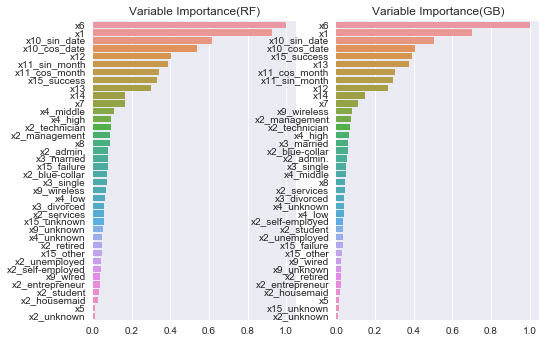

In [16]:
# Variable importance for random forest
rf_fi = rf_model.feature_importances_
rf_fi = rf_fi / rf_fi.max()
featureNames = np.array([col for col in X_train])
rf_idxSorted = np.argsort(rf_fi)[::-1]

# Variable importance for gradient boosting
gb_fi = gb_model.feature_importances_
gb_fi = gb_fi / gb_fi.max()
gb_idxSorted = np.argsort(gb_fi)[::-1]

# Plot variable(feature) importance
f1, (fi_ax1, fi_ax2) = sns.plt.subplots(1, 2)
sns.barplot(x=rf_fi[rf_idxSorted], y=featureNames[rf_idxSorted], ax=fi_ax1)
fi_ax1.set_title("Variable Importance(RF)")
sns.barplot(x=gb_fi[gb_idxSorted], y=featureNames[gb_idxSorted], ax=fi_ax2)
fi_ax2.set_title("Variable Importance(GB)")
sns.plt.show()

두 모델의 변수 중요도를 비교하면 연평균잔고(x6), 연령(x1), 마지막 연락일(x10) 순으로 동일하게 나타나며, 이후에는 차이가 있습니다.

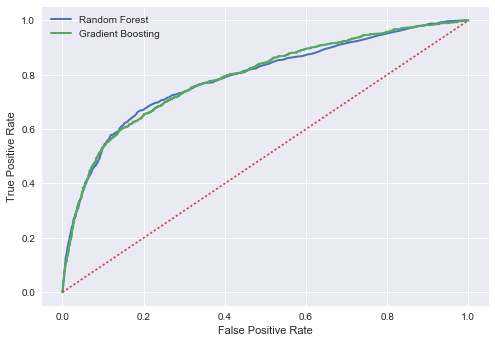

In [17]:
# Plot ROC
rf_fpr, rf_tpr, rf_thresh = roc_curve(y_valid, list(rf_pred[:,1]))
gb_fpr, gb_tpr, gb_thresh = roc_curve(y_valid, list(pBest))
ctClass = [i*0.01 for i in range(101)]

f2 = plt.figure()
ax = plt.subplot(111)
plt.plot(rf_fpr, rf_tpr, linewidth=2, label="Random Forest")
plt.plot(gb_fpr, gb_tpr, linewidth=2, label="Gradient Boosting")
plt.plot(ctClass, ctClass, linestyle=':')
ax.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
sns.plt.show()

두 모델의 성능은 비슷한 것으로 나타납니다.

ROC Plot에서 Best Case (TP=1, FP=0)인 지점으로부터 Euclidean distance가 최소인 지점을 찾습니다. TP rate과 FP rate 중 어느 지표에 더 가중치를 두느냐에 따라 결과가 달라지지만 이 분석에서는 두 지표의 가중치가 같다고 가정합니다.

In [18]:
# Find the closest threshold point from the best
rf_best_thr = roc_best_cutoff(y_valid, rf_model.predict_proba(X_valid))
gb_best_thr = roc_best_cutoff(y_valid, gb_model.predict_proba(X_valid))


Best point on the ROC: TPR = 69.223%, FPR = 22.186%

Best Cut-Off threshold: 0.1350

Best point on the ROC: TPR = 70.333%, FPR = 25.724%

Best Cut-Off threshold: 0.0890


# Confusion Matrix

Random Forest의 성능은 아래와 같습니다.

             precision    recall  f1-score   support

          0       0.95      0.78      0.85      7009
          1       0.31      0.69      0.42       991

avg / total       0.87      0.77      0.80      8000

Classification Report:

             precision    recall  f1-score   support

          0       0.95      0.78      0.85      7009
          1       0.31      0.69      0.42       991

avg / total       0.87      0.77      0.80      8000


 Confusion matrix, without normalization: 

[[5454 1555]
 [ 305  686]]


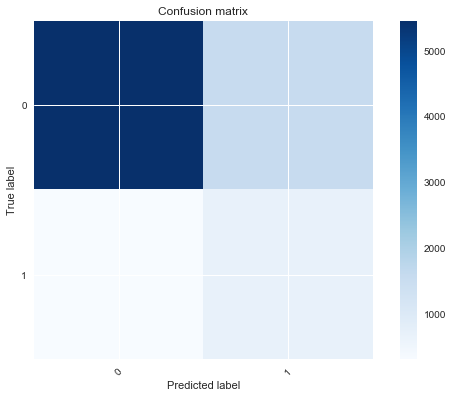


 Normalized confusion matrix 

[[ 0.77814239  0.22185761]
 [ 0.30776993  0.69223007]]


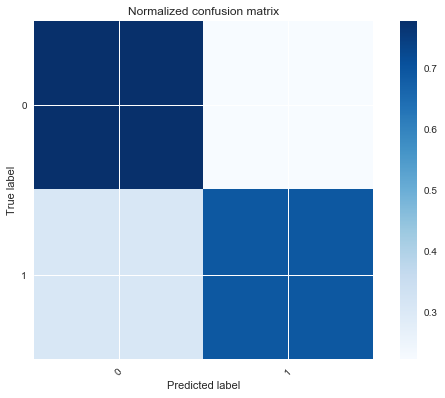

In [19]:
# Random Forest: Classification result and confusion matrix
rf_best_pred = pred_from_thresh(rf_model, X=X_valid, thr=rf_best_thr)
print(classification_report(y_valid, rf_best_pred))
plot_confusion_matrix(y_true=y_valid, y_pred=rf_best_pred, title="RF confusion matrix")

Gradient Boosting Model의 성능은 아래와 같습니다.

             precision    recall  f1-score   support

          0       0.95      0.74      0.83      7009
          1       0.28      0.70      0.40       991

avg / total       0.86      0.74      0.78      8000

Classification Report:

             precision    recall  f1-score   support

          0       0.95      0.74      0.83      7009
          1       0.28      0.70      0.40       991

avg / total       0.86      0.74      0.78      8000


 Confusion matrix, without normalization: 

[[5206 1803]
 [ 295  696]]


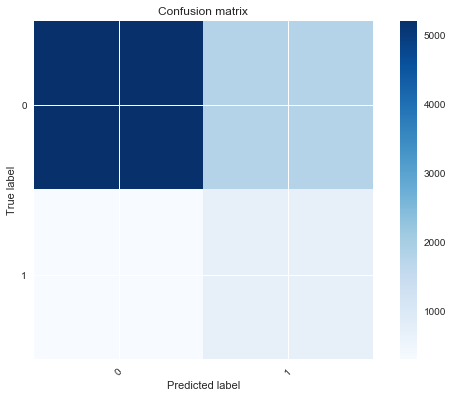


 Normalized confusion matrix 

[[ 0.74275931  0.25724069]
 [ 0.29767911  0.70232089]]


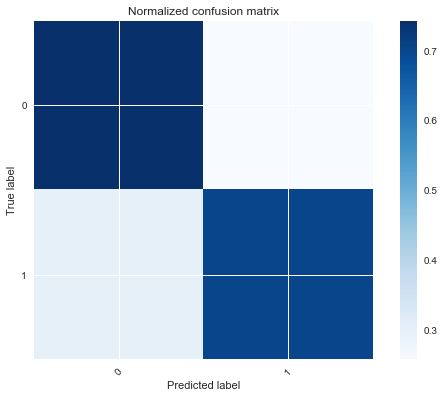

In [21]:
# Gradient Boosting: Classification result and confusion matrix
gb_best_pred = pred_from_thresh(gb_model, X=X_valid, thr=gb_best_thr)
print(classification_report(y_valid, gb_best_pred))
plot_confusion_matrix(y_true=y_valid, y_pred=gb_best_pred, title="GB confusion matrix")